# Conversational Threads
Threads in LangSmith track multi-turn conversations between users and LLM applications. Essential for maintaining context across conversation history in chatbot interfaces like RAG applications.

### setup


In [1]:
from dotenv import load_dotenv
load_dotenv()

True

### Group traces into threads
Threads = linked conversation traces

A Thread groups multiple traces from one conversation. Each response is its own trace, connected by a shared thread identifier.

To link traces = passa metadata key with that thread'sunique ID. 
Accepted key names:
* session_id
* thread_id
* conversation_id
The value should be a UUID (unique identifier for that specific conversation)

basically this lets you track full conversation history instead of isolated responses. Critical for chatbots that need context from earlier messages - like our RAG app remembering what users asked before.

In [2]:
import uuid
thread_id = uuid.uuid4

In [3]:
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

@traceable(run_type="llm")
def call_openai(
    messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    return openai_client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )

@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

USER_AGENT environment variable not set, consider setting it to identify your requests.


Let's run our application with this thread about 2 or more times to mimic a conversation

In [5]:
question = "What's the easiest way connect metadata to a thread?"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

The easiest way to connect metadata to a thread is by passing a special metadata key with a unique identifier for that thread. You can use keys like `session_id`, `thread_id`, or `conversation_id`, and it's recommended to use UUIDs for the values. This allows you to group traces into a single conversation thread effectively.


In [7]:
question = "How to add tags to threads and why is it important to do so"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

To add tags to threads in LangChain, you can create a tag in the workspace settings and then assign it to the relevant thread. Tags help organize and filter resources within a workspace, making it easier to manage and track conversations. This organization is crucial for observability and evaluation of LLM applications.


In [9]:
question = "My name is Viraja and I really like ice creams above all"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

That's great to hear, Viraja! Ice cream is a popular treat enjoyed by many. Do you have a favorite flavor?


In [11]:
question = "yeah it's chocolate"
ai_answer = langsmith_rag(question, langsmith_extra={"metadata": {"thread_id": thread_id}})
print(ai_answer)

I don't know.


We can now see the "thread" option, meaning we succesfully learnt to use thread_id
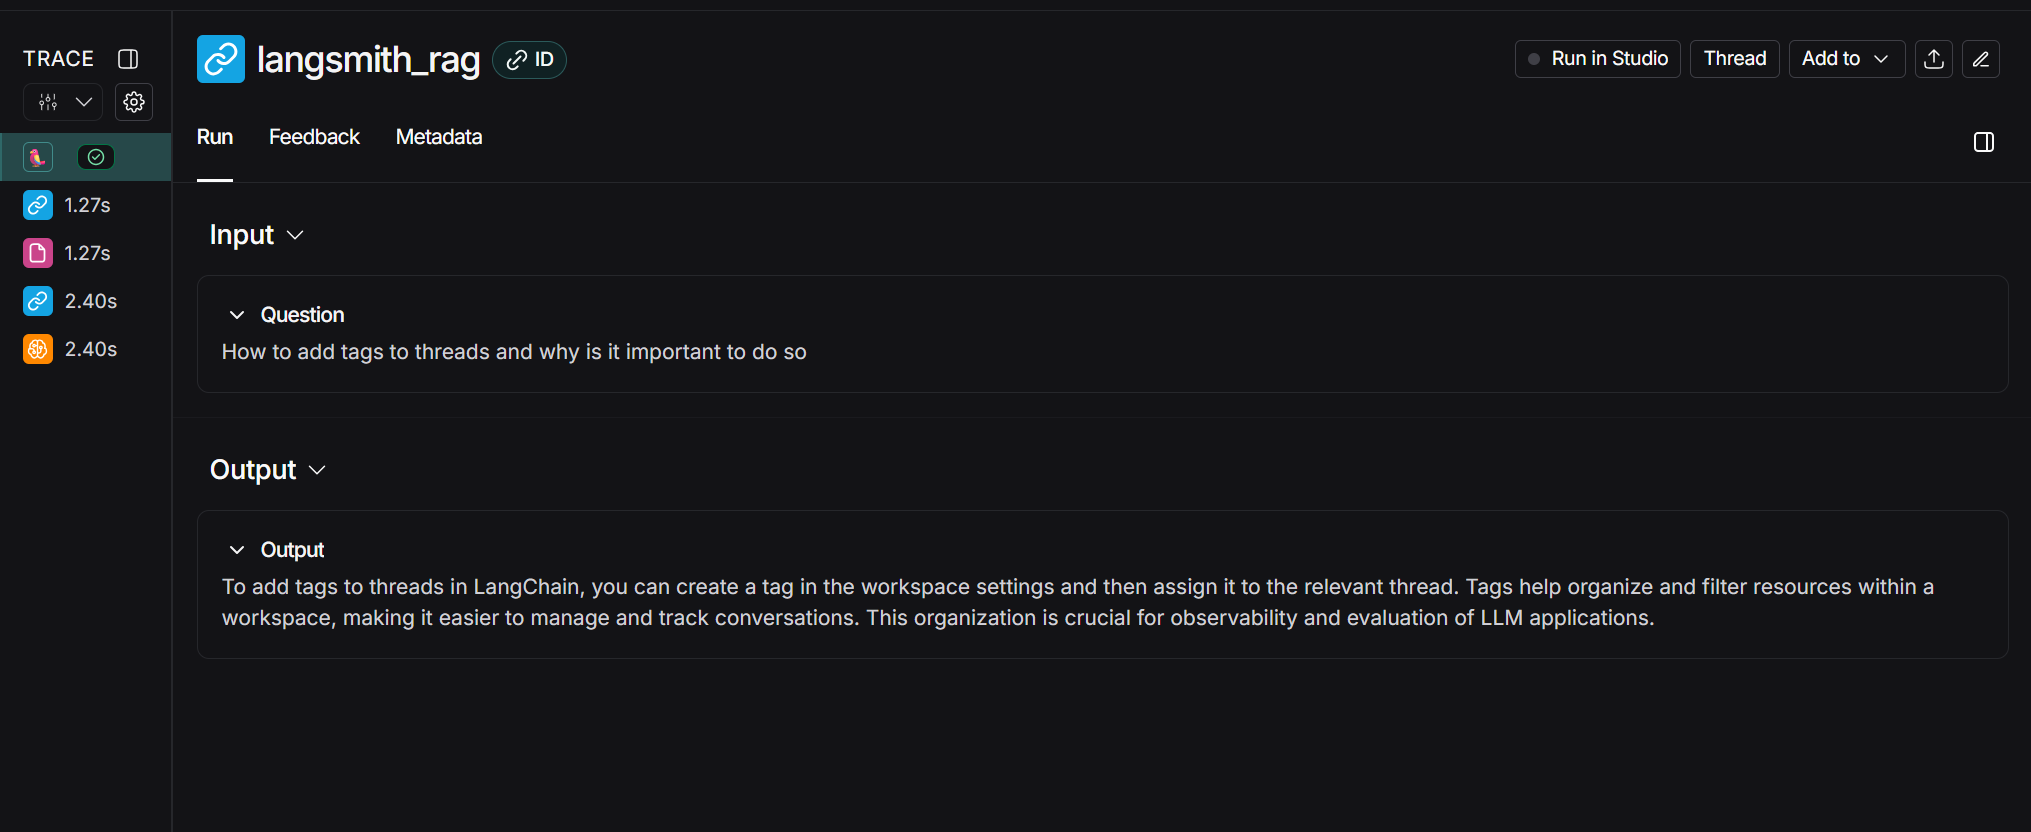
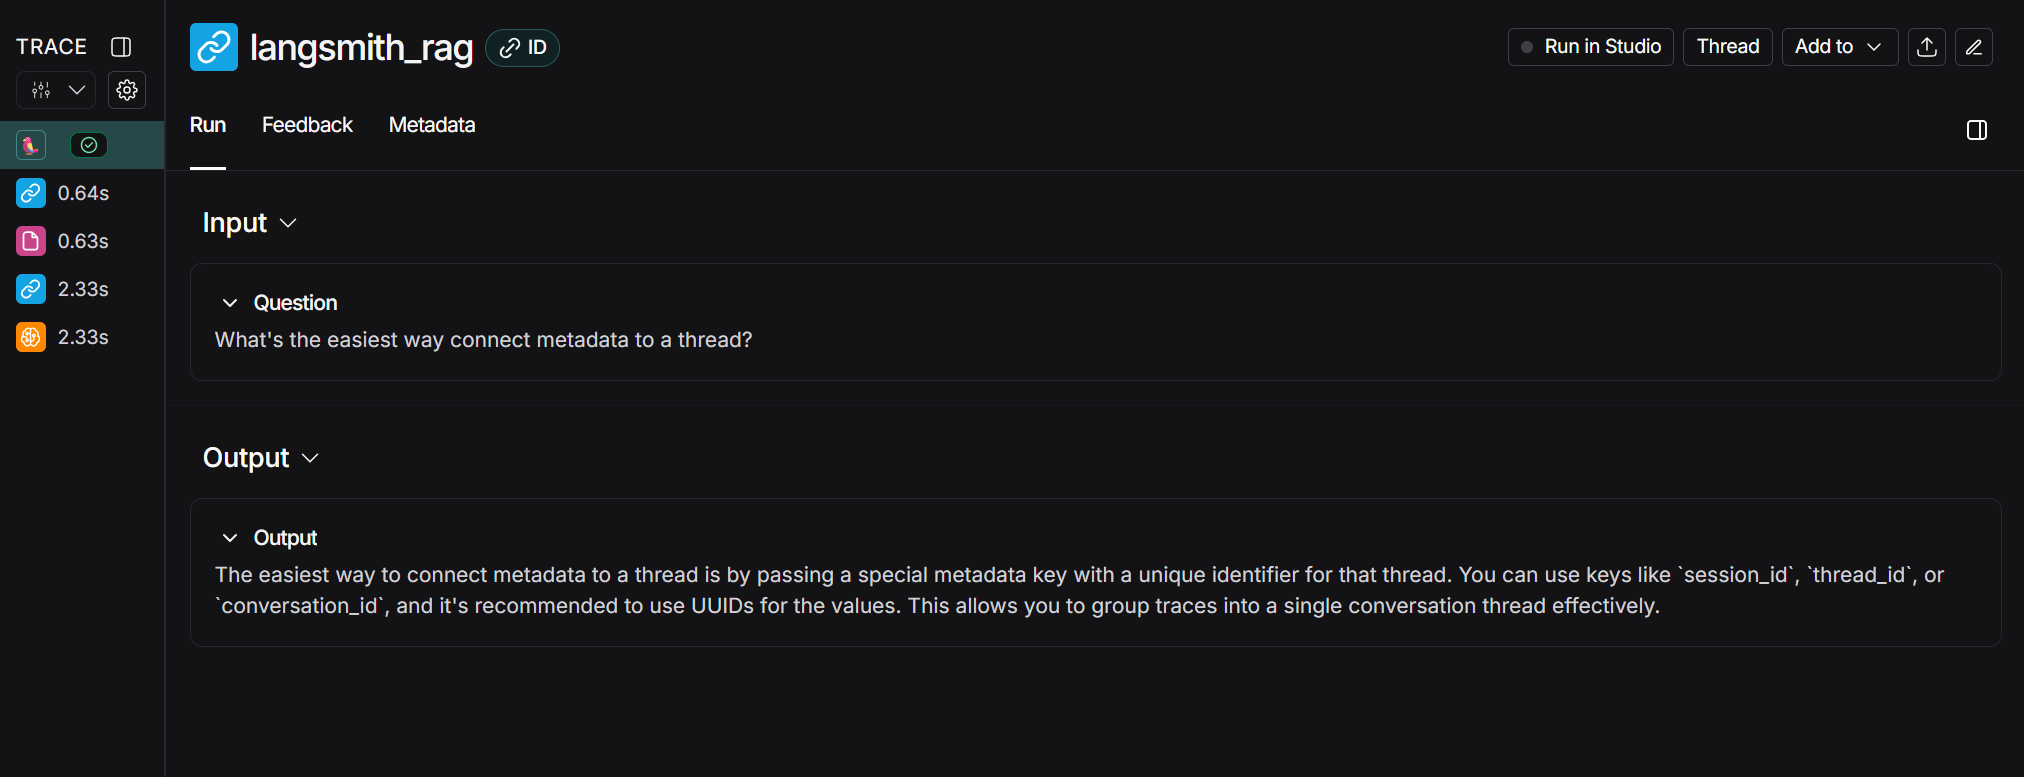

And by selecting the thread view option we can view the entire conversation and its history. It also allows us to step into an individual trace.
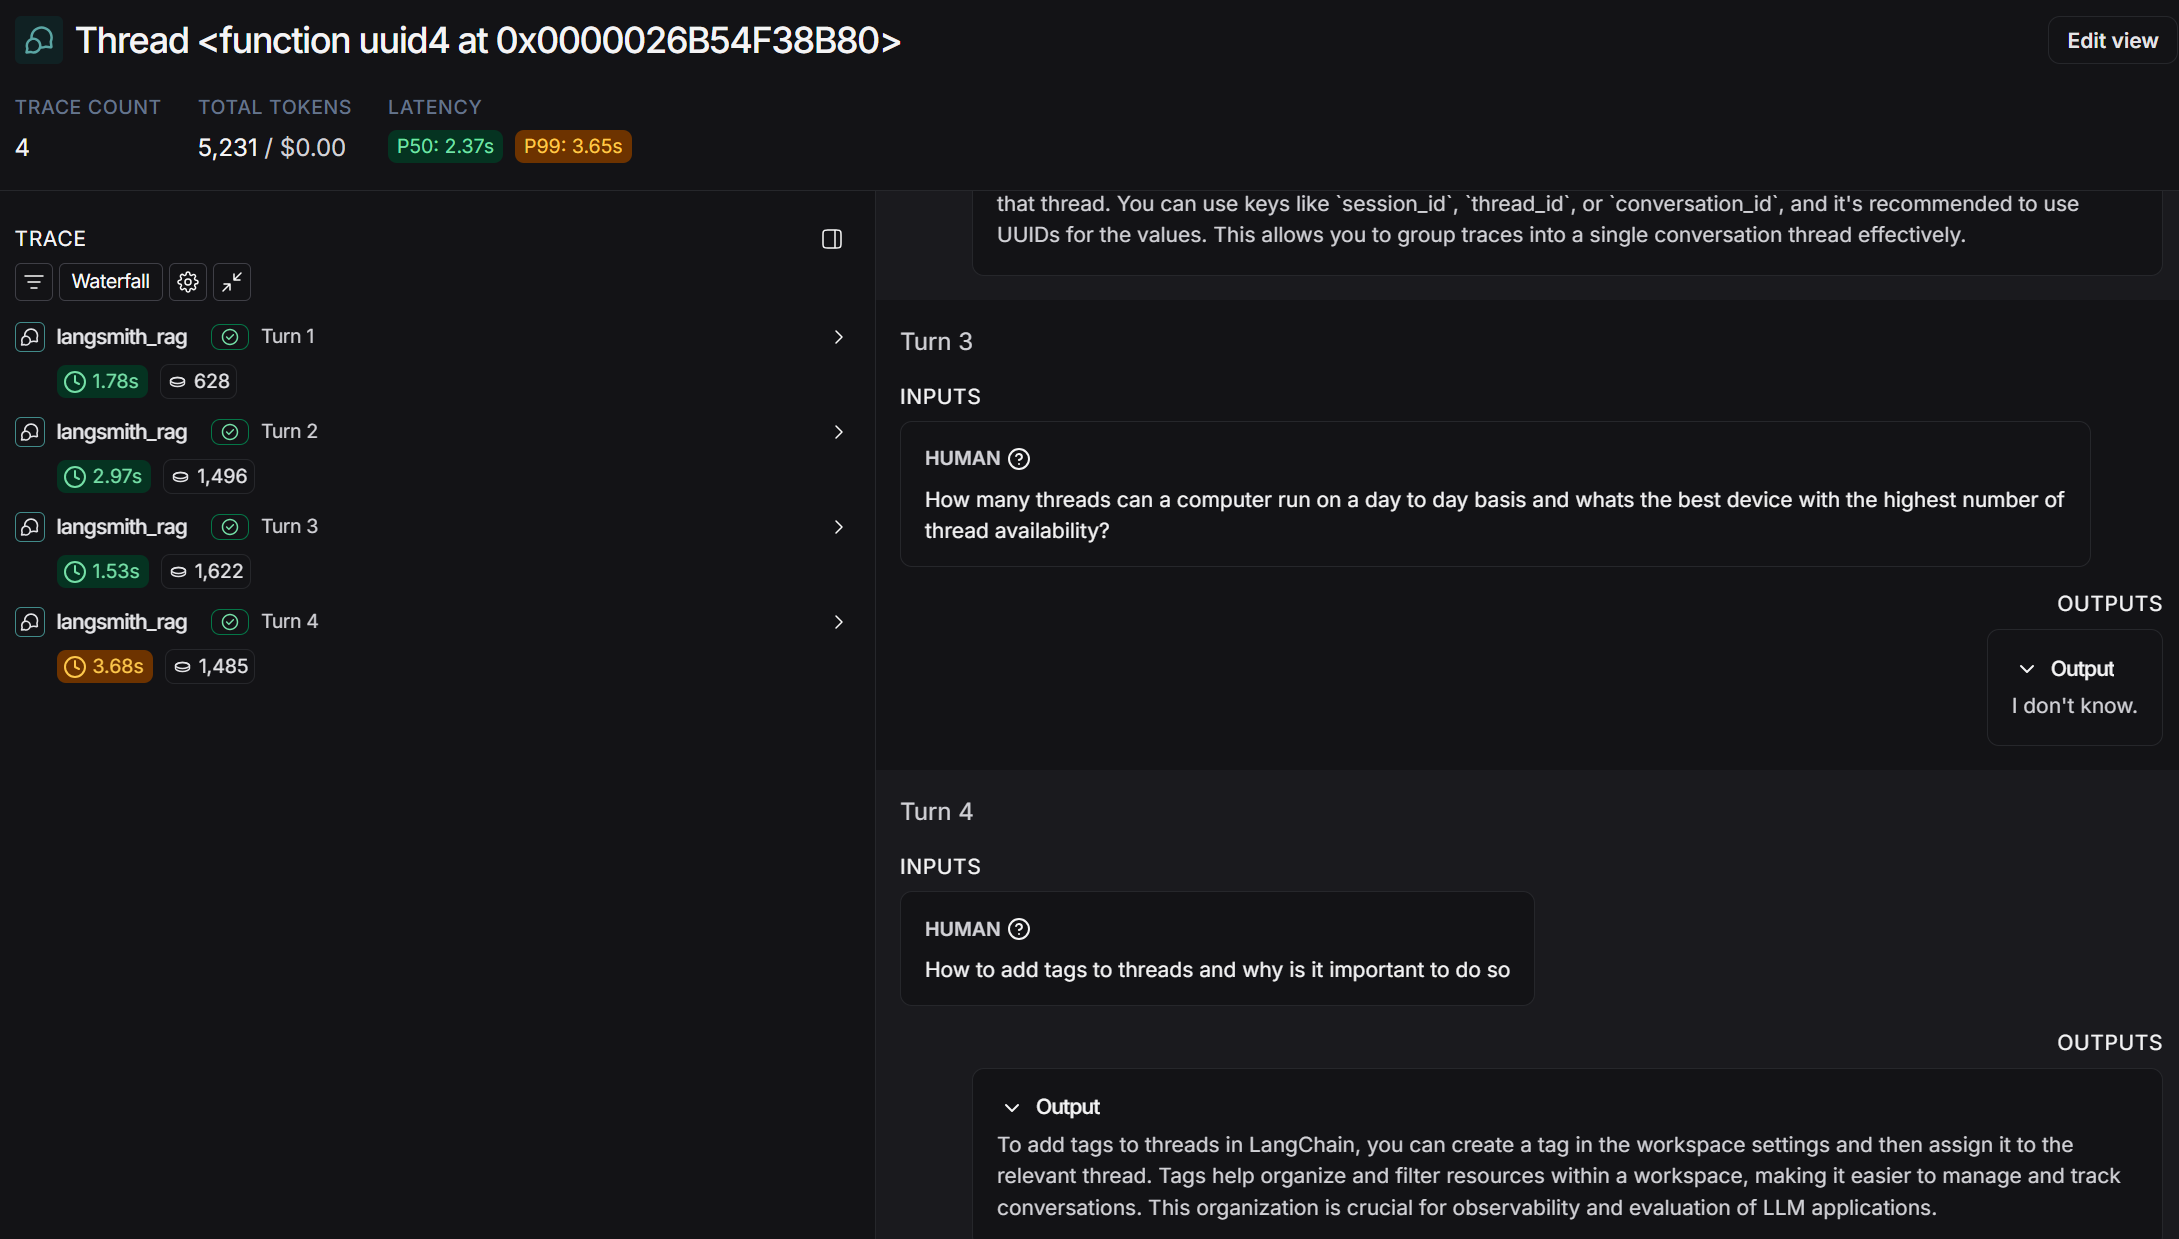

To make it easier to debug a full interaction with a user that mgiht have taken multiple traces, we have a direct threads view: 
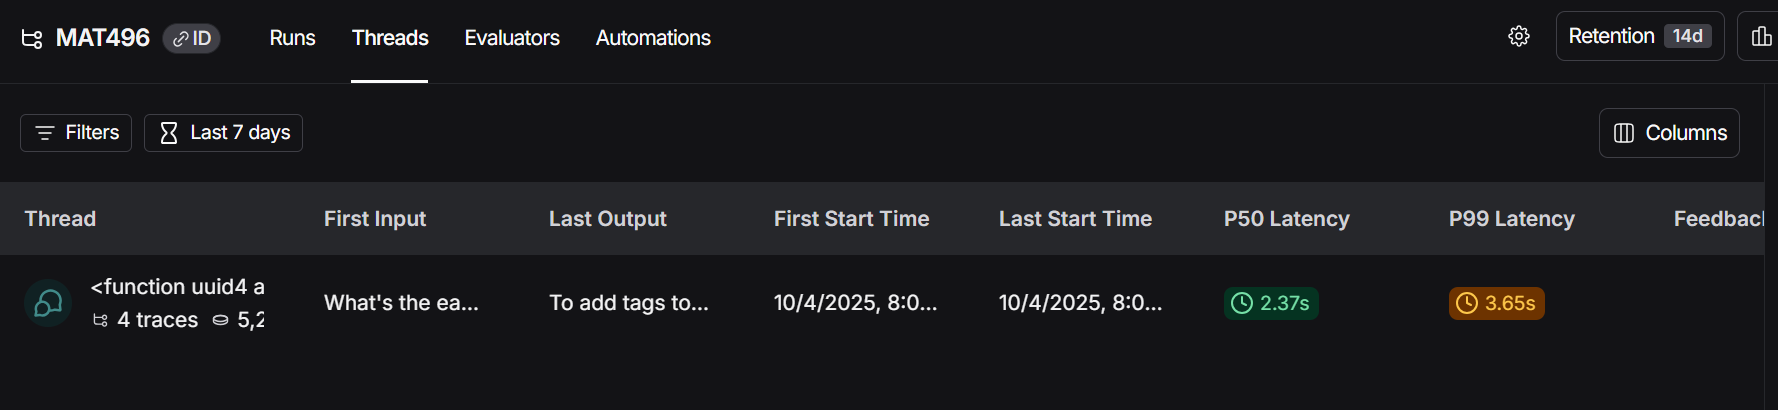